# Import Packages

In [1]:
import numpy as np 
import pandas as pd
import ast
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import statistics
from sklearn.metrics import r2_score

# Read Data

In [2]:
data=pd.read_csv('../data/price_data.csv')  

# Preprocess Data

1.id is a random number and address is unique value.

2.brokers, buildingName, dateAdded, dateUpdated, mlsNumber, phones, taxID should not affect housing price.
descriptions and reviews analysis are similar to what we have done for task 1.

3.So much infomation lost in deposits, languageSpoken, LeasingTerms, listingName, numPeople, numRoom, paymentTypes, people, rules

4.city, country, FloorSizeUnit, geoLocation, neighborhoods, postalCode, province for CA 90005 are same/similar

5.geolocation is same as lattitude and longitude

6.mostRecentStatus, statuses is not meaningful for calculating occupancy rate or prices

7.propertyTaxes and prices are directly correlated (ie. proportional to each other)

some other attributes should not affect prices

From reasons listed above, we should deletd these useless/repetitive columns

Note: Since Features has a lot to explore and I don't have so much time on it so I drop i, but we can expand information in it to predict prices

After investigation, parking information doesn't have consistant formats, so we cannot have a standard to classify information and use in our analysis

In [3]:
#delete repetitive and useless columns
df = data.drop(columns=['id','address', 'fees','brokers','features' ,'buildingName','city','country','dateAdded','dateUpdated','deposits','descriptions','floorSizeUnit','geoLocation','languagesSpoken','leasingTerms','listingName','managedBy','mostRecentStatusDate','mostRecentStatus','mlsNumber','neighborhoods','numPeople',
                          'numRoom','paymentTypes','people','phones','postalCode','province','reviews','rules','taxID','propertyTaxes','statuses','parking'], axis=1)

In [4]:
# delete rows with 50% missing values
df = df.dropna(thresh=7)

## change string to numbers

#### clean price

In [5]:
#clean prices into Max and Min price

def get_string_dic(row):
    if row['prices']!=np.nan:
        d = "},"
        no_list=[e+d for e in str(row['prices']).strip('][').split(d) if e]
        no_list=[e.strip('},')+'}' for e in no_list] #get rid of brackets and split dictionaries
        return no_list
    return np.nan


#s =  [e+d for e in line.split(d) if e]
def get_max_min(row):
    recent_record=row['string_dic'][0]
    if recent_record!='nan}':
        dict_val=ast.literal_eval(recent_record)
        max_amount=dict_val["amountMax"]
        min_amount=dict_val["amountMin"]
        return [min_amount,max_amount]
    return np.nan

df['string_dic']=df.apply (lambda row: get_string_dic(row), axis=1)#get rid of the list 
df['price_range']=df.apply (lambda row: get_max_min(row), axis=1)#get price range from recent record

In [6]:
#seperate price range to max and min and drop price range, string_dic, prices which are repetitve for our new columns
df["Min_price"] = df["price_range"].str[0]
df["Max_price"] = df["price_range"].str[1]
df.drop(columns=['prices','string_dic','price_range'], axis=1, inplace=True)

#### clean pet policy

In [7]:
df['petPolicy'] = df['petPolicy'].fillna('NaN')

In [8]:
def clean_pet(row):
    if 'no' in str(row['petPolicy']).lower():
        return 1
    elif row['petPolicy']=='NaN':
        return np.nan
    else :
        return 0

In [9]:
#0 means it doesn't have restriction on pet and 1 mean it has
df['Pet_restriction']=df.apply (lambda row: clean_pet(row), axis=1)#get pet restriction column 

In [10]:
df.drop(columns='petPolicy', axis=1, inplace=True)

#### clean property type

Since we don't have any null values in property type with our data now, we can convert to dummy variables as a dataframe directly and concate two dataframes together.

In [11]:
# creating an object 
# of the LabelBinarizer
label_binarizer = LabelBinarizer()
  
# fitting the column 
label_binarizer_output = label_binarizer.fit_transform( df['propertyType'])
  
# creating a data frame from the object
result_df= pd.DataFrame(label_binarizer_output,
                         columns = label_binarizer.classes_)
  
#concatenate two dataframes together
df.reset_index(drop=True, inplace=True)

result = pd.concat([df, result_df], axis=1)

#drop propertyType
result.drop('propertyType', axis=1, inplace=True)

#### clean lot size unit

In [12]:
result.lotSizeUnit.unique() #check if it's binary or multiclass

array([nan, 'sq ft', 'acs'], dtype=object)

In [13]:
result['lotSizeUnit'] =result['lotSizeUnit'].fillna('NaN')
def clean_lot_unit(row):
    if str(row['lotSizeUnit'])=='sq ft':
        return 1
    elif row['lotSizeUnit']=='NaN':
        return np.nan
    else :
        return 0

In [14]:
#0 means it's acs and 1 means it's sq ft
result['Lot_size_unit']=result.apply (lambda row: clean_lot_unit(row), axis=1)#get pet restriction column 

In [15]:
result.drop(columns='lotSizeUnit', axis=1, inplace=True)

### clean longitude

In [16]:
#convert to positive for calculation/visulization
result['longitude']=-result['longitude']

## Clean Missing values

### visualize locations

Text(0, 0.5, 'latitude')

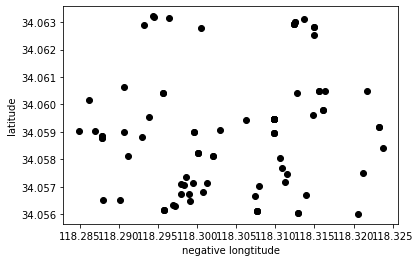

In [17]:
plt.plot(result['longitude'], result['latitude'], 'o', color='black')
plt.xlabel("negative longtitude")
plt.ylabel("latitude")

### Kmeans Clustering

From the plots we can see some data points can be clustered. Since apartments/houses in similar latitude and longitude should share similar floorsize, numBathroom, numBedroom, numUnit, petPolicy, property type, price, I believe we can fill missing values of data points with the data points in the same cluster.

In [18]:
features=result.iloc[:,1:3]
features.isnull().sum() #no null 

latitude     0
longitude    0
dtype: int64

In [19]:
#find optimal k
def find_optimal_k(features):
    silhouette_coefficients = {}
    for k in range(2,51):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        silhouette_coefficients [str(k)]=score
    optimal_k=int(max(silhouette_coefficients, key=silhouette_coefficients.get))# best k with scores
    return optimal_k

In [20]:
optimal_k=find_optimal_k(features)
kmeans = KMeans(n_clusters=optimal_k,random_state=0)
kmeans.fit(features)
result['Cluster']=kmeans.labels_

### Find what filling value is appropriate for each column (visualize)

Note: For dummy variables, I will replace missing values with majority vote for each cluster since it has no median, mean, minimum, etc.

In [21]:
#find out which columns have missing values
result.isnull().sum()

floorSizeValue            20
latitude                   0
longitude                  0
lotSizeValue              57
numBathroom                2
numBedroom                24
numFloor                  66
numUnit                   29
yearBuilt                 46
Min_price                  6
Max_price                  6
Pet_restriction           40
Apartment                  0
Commercial                 0
Condo                      0
Industrial                 0
Multi-Family Dwelling      0
Single Family Dwelling     0
Lot_size_unit             57
Cluster                    0
dtype: int64

Text(0, 0.5, 'Floor Size Value')

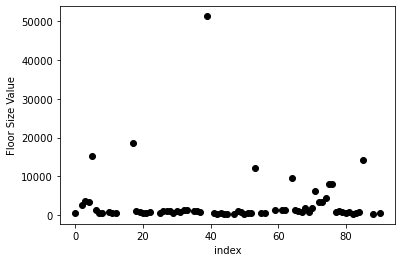

In [22]:
# Visualize floorSizeValue
plt.plot(result.index.tolist(), result['floorSizeValue'], 'o', color='black')
plt.xlabel("index")
plt.ylabel("Floor Size Value")

From the plot above, we can see that most data points are around 0-10000 with little outliers, so it's appropriate for us to use overall median values of floor size value to replace missing values. (bc outliers has little effect on median values)

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Lot Size Value')]

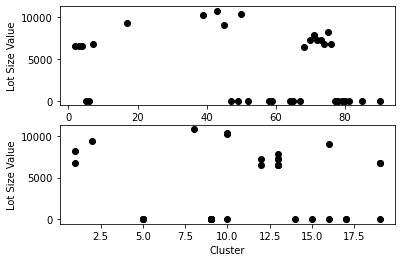

In [23]:
# Visualize lot size value 
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['lotSizeValue'], 'o', color='black')
axs[1].plot(result['Cluster'], result['lotSizeValue'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="Lot Size Value")
axs[1].set(xlabel="Cluster", ylabel="Lot Size Value")

From comparision of two graphs above, we can see the trend for Lot Size Value is more explainable. For each cluster, most points are close to each other with some outliers. Thus, we will use median of Lot Size Value in each cluster to replace missing values. Furthermore, since LotSizeUnit is corresponding to LotSizeValue, so we will also replace missing values with median for each cluster in LotSizeUnit.

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'numBathroom')]

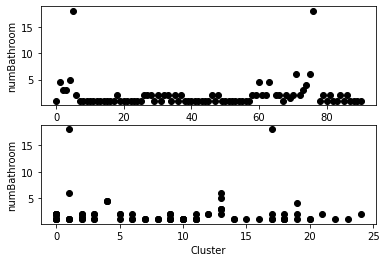

In [24]:
# Visualize numBathroom 
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['numBathroom'], 'o', color='black')
axs[1].plot(result['Cluster'], result['numBathroom'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="numBathroom")
axs[1].set(xlabel="Cluster", ylabel="numBathroom")

From comparision of two graphs above, we can see the trend for numBathroom is more explainable. For each cluster, most points are close to each other with some outliers. Thus, we will use median of numBathroom in each cluster to replace missing values

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'numBedroom')]

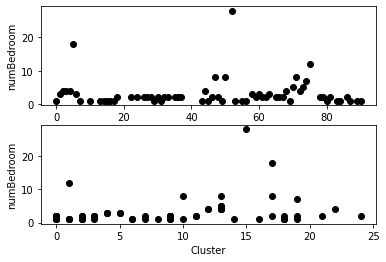

In [25]:
# Visualize numBedroom 
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['numBedroom'], 'o', color='black')
axs[1].plot(result['Cluster'], result['numBedroom'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="numBedroom")
axs[1].set(xlabel="Cluster", ylabel="numBedroom")

Similar to numBathroom, from comparision of two graphs above, we can see the trend for numBedroom is more explainable in clusters. For each cluster, most points are close to each other with some outliers. Thus, we will use median of numBedroom in each cluster to replace missing values

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'numFloor')]

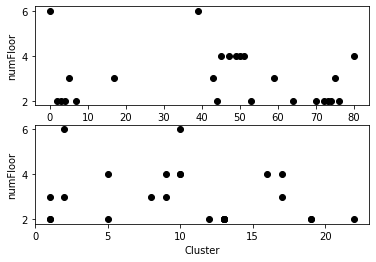

In [26]:
# Visualize numFloor  
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['numFloor'], 'o', color='black')
axs[1].plot(result['Cluster'], result['numFloor'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="numFloor")
axs[1].set(xlabel="Cluster", ylabel="numFloor")

From graphs above, we don't see any clear trend or outliers because limited known information. However, from conclusion with numBedroom and numBathroom, it will be better to replace missing values in numFloor with median for each cluster.

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'numUnit')]

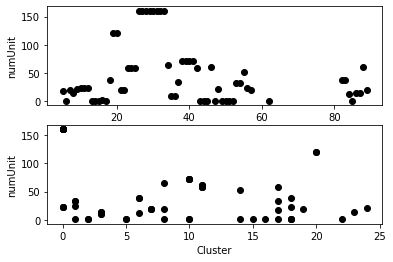

In [27]:
# Visualize numUnit 
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['numUnit'], 'o', color='black')
axs[1].plot(result['Cluster'], result['numUnit'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="numUnit")
axs[1].set(xlabel="Cluster", ylabel="numUnit")

Similar to numBathroom, from comparision of two graphs above, we can see the trend for numUnit is more explainable in clusters. For each cluster, most points are close to each other with some outliers. Thus, we will use median of numUnit in each cluster to replace missing values

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'yearBuilt')]

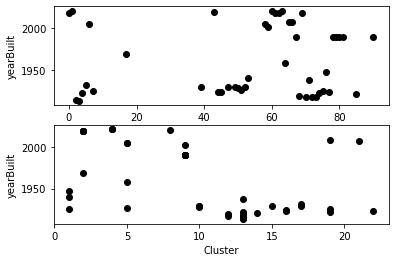

In [28]:
# Visualize yearBuilt
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['yearBuilt'], 'o', color='black')
axs[1].plot(result['Cluster'], result['yearBuilt'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="yearBuilt")
axs[1].set(xlabel="Cluster", ylabel="yearBuilt")

Similar to numBathroom, from comparision of two graphs above, we can see the trend for yearBuilt is more explainable in clusters. For each cluster, most points are close to each other with some outliers. Thus, we will use median of yearBuilt in each cluster to replace missing values

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Min_price')]

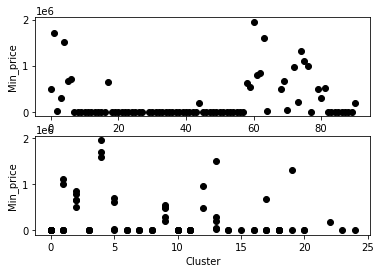

In [29]:
# Visualize Min_price
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['Min_price'], 'o', color='black')
axs[1].plot(result['Cluster'], result['Min_price'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="Min_price")
axs[1].set(xlabel="Cluster", ylabel="Min_price")

Similar to numBathroom, from comparision of two graphs above, we can see the trend for Min_price is more explainable in clusters. For each cluster, most points are close to each other with some outliers. Thus, we will use median of Min_price in each cluster to replace missing values

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Max_price')]

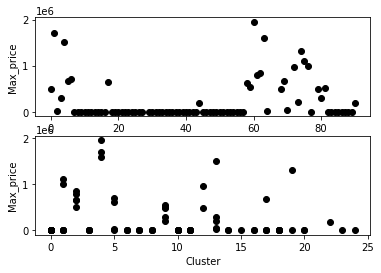

In [30]:
# Visualize Max_price
fig, axs = plt.subplots(2)
axs[0].plot(result.index.tolist(), result['Max_price'], 'o', color='black')
axs[1].plot(result['Cluster'], result['Max_price'], 'o', color='black')
axs[0].set(xlabel="index", ylabel="Max_price")
axs[1].set(xlabel="Cluster", ylabel="Max_price")

Same as Min_price.

### Clean Missing values with appropriate values listed above

In [31]:
#clean for floorSizeValue
med_floorSize=np.nanmedian(result['floorSizeValue'])
result['floorSizeValue']=result['floorSizeValue'].fillna(med_floorSize)

In [32]:
#fill nan with 'NaN'
'''result['lotSizeValue'] =result['lotSizeValue'].fillna('NaN')
result['numBathroom'] =result['numBathroom'].fillna('NaN')
result['numBedroom'] =result['numBedroom'].fillna('NaN')
result['numFloor'] =result['numFloor'].fillna('NaN')
result['numUnit'] =result['numUnit'].fillna('NaN')
result['yearBuilt'] =result['yearBuilt'].fillna('NaN')
result['Min_price'] =result['Min_price'].fillna('NaN')
result['Max_price'] =result['Max_price'].fillna('NaN')
result['Pet_restriction'] =result['Pet_restriction'].fillna('NaN')
result['Lot_size_unit'] =result['Lot_size_unit'].fillna('NaN')'''

"result['lotSizeValue'] =result['lotSizeValue'].fillna('NaN')\nresult['numBathroom'] =result['numBathroom'].fillna('NaN')\nresult['numBedroom'] =result['numBedroom'].fillna('NaN')\nresult['numFloor'] =result['numFloor'].fillna('NaN')\nresult['numUnit'] =result['numUnit'].fillna('NaN')\nresult['yearBuilt'] =result['yearBuilt'].fillna('NaN')\nresult['Min_price'] =result['Min_price'].fillna('NaN')\nresult['Max_price'] =result['Max_price'].fillna('NaN')\nresult['Pet_restriction'] =result['Pet_restriction'].fillna('NaN')\nresult['Lot_size_unit'] =result['Lot_size_unit'].fillna('NaN')"

In [33]:
#clean other values (not working for this dataset)
def clean_pet_restriction(df,df_with_na,opt_k):
    df['majority_pet_restriction']=np.nan
    for i in range(opt_k):
        majority_restriction=df_with_na.dropna().loc[df['Cluster'] == i].groupby('Pet_restriction').count().iloc[:,0].idxmax()
        df.loc[(df.Cluster == i) & (df.Pet_restriction=='NaN'), 'Pet_restriction'] = majority_restriction #clean pet restriction
    print(df)

We tried to use majority vote/median for each clusters to clean other values, but because the dataset is small and null values are many, majority vote/median for some clusters are NaN, so we use medians and majority vote of the whole dataset instead of the clusters. However, filling na with majority vote/median for each cluster should be possible for larger dataset.

In [34]:
#clean for other variables
med_lotSizeValue=np.nanmedian(result['lotSizeValue'])
result['lotSizeValue']=result['lotSizeValue'].fillna(med_lotSizeValue)

med_numBathroom=np.nanmedian(result['numBathroom'])
result['numBathroom']=result['numBathroom'].fillna(med_numBathroom)

med_numBedroom=np.nanmedian(result['numBedroom'])
result['numBedroom']=result['numBedroom'].fillna(med_numBedroom)

med_numFloor=np.nanmedian(result['numFloor'])
result['numFloor']=result['numFloor'].fillna(med_numFloor)

med_numUnit=np.nanmedian(result['numUnit'])
result['numUnit']=result['numUnit'].fillna(med_numUnit)

med_yearBuilt=np.nanmedian(result['yearBuilt'])
result['yearBuilt']=result['yearBuilt'].fillna(med_yearBuilt)

med_Min_price=np.nanmedian(result['Min_price'])
result['Min_price']=result['Min_price'].fillna(med_Min_price)

med_Max_price=np.nanmedian(result['Max_price'])
result['Max_price']=result['Max_price'].fillna(med_Max_price)

med_Lot_size_unit=np.nanmedian(result['Lot_size_unit'])
result['Lot_size_unit']=result['Lot_size_unit'].fillna(med_Lot_size_unit)


result['Pet_restriction']=result['Pet_restriction'].fillna(result.groupby('Pet_restriction').count().iloc[:,0].idxmax())


In [35]:
#check which columns still have missing values
result.isnull().sum()

floorSizeValue            0
latitude                  0
longitude                 0
lotSizeValue              0
numBathroom               0
numBedroom                0
numFloor                  0
numUnit                   0
yearBuilt                 0
Min_price                 0
Max_price                 0
Pet_restriction           0
Apartment                 0
Commercial                0
Condo                     0
Industrial                0
Multi-Family Dwelling     0
Single Family Dwelling    0
Lot_size_unit             0
Cluster                   0
dtype: int64

## Occupancy Rate

The Occupancy is not indicated in this dataset and it's also not obvious in other datasets from the websites. Thus, I believe that we can find corresponding occupancy for each apartment one by one from LADBS. If I have time, I will create the occupancy column with information from LADBS and analyze the occupancy rate.

## Prediction of Pricing Range with Linear Regression

In [36]:
#Since we use latitude and longtitude to replace missing values, some features will be highly correlated. Thus, we need to use LASSO regression
X=result.drop(['Min_price', 'Max_price'], axis=1)
Y_min=np.log(result['Min_price'])
Y_max=np.log(result['Max_price'])
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X, Y_min, test_size=0.33, random_state=42)
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X, Y_max, test_size=0.33, random_state=42)

### pred for min_price

In [37]:
#create model and fit
reg=linear_model.LinearRegression()
reg.fit(X_train_min, y_train_min)
reg_pred = abs(reg.predict(X_test_min))

In [38]:
mean_squared_error(y_test_min, reg_pred)
print("R2 score : %.2f" % r2_score(y_test_min, reg_pred))

R2 score : -0.82


### pred for max_price

In [39]:
#create model and fit
reg=linear_model.LinearRegression()
reg.fit(X_train_max, y_train_max)
reg_pred = reg.predict(X_test_max)

From the R^2 score, we know that linear regression is not appropriate for prediction or should be improved.
We can try serveral models like KNN, LASSO, Ridge Regression, etc. to see if there are improvements.
Also, we can adjust our ways of filling missing values and filtering out some outliers to see if there are improvements.